In [29]:
import os
import torch
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from datasets.UCEIS_dataset import UCEIS_cord, UCEIS_csv
from models import resnet
from utils.provider import get_all_level_bucketing_accuracy, get_stratified_UCEIS_accuracies, plot_confusion_matrix_2, convert_multiclass_to_binary_class
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [30]:
file = open("C://Users//elif//Desktop//gi//Code//splitted_folder_names//train_folders.txt", "r")
train_folders = file.read().splitlines()
file.close()

In [44]:
#train_folders = [
#'video137'
#'video162'
#'video107'
#'video89'
#'video149'
#'video159'
#'Video_20.mp4'
#'video86'
#'video128'
#'Video_14.mp4',
#'video15'
#]

In [31]:
model_name = "ResNet34"
num_worker=4

frame_root = "C:\\Users\\elif\\Desktop\\gi\\IBD\\data_all_frames_540x960"
cord_project_ID = '5c349378-3e58-4028-af97-96ad9d137dd3'
cord_API_key = 'fL_ktLRxfD90iQayw2dLVg-GVkPxQZVq9p6C6cvpvlg'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda:0


In [32]:
uceis_list = []
vascular_list=[]
bleeding_list=[]
erosion_list=[]
#### Model I used for Surgease paper results
state_dict_name = "weights/9_best_"+model_name+".pth.tar"

if model_name == "ResNet18":
    model = resnet.resnet18(num_classes=[3, 4, 4])
elif model_name == "ResNet34":
    model = resnet.resnet34(num_classes=[3, 4, 4])
elif model_name == "ResNet50":
    model = resnet.resnet50(num_classes=[3, 4, 4])
elif model_name == "DenseNet201":
    model = densenet.densenet201(num_classes=[3, 4, 4])
elif model_name == "DenseNet121":
    model = densenet.densenet121(num_classes=[3, 4, 4])

model.load_state_dict(torch.load(state_dict_name, map_location=device))
model.to(device)
model.eval()

for file in train_folders:
    print(file)
    normalize = transforms.Normalize(mean=[0.3682399440284867, 0.2694662632497621, 0.20368512286738416],
                                 std=[0.3335210190878823, 0.2446521312241275, 0.19399928544661488])

    test_transform = transforms.Compose([transforms.ToTensor(),
                                        normalize])

    #test_dataset = UCEIS_cord([file], frame_root, cord_project_ID, cord_API_key, transform=test_transform)
    test_dataset = UCEIS_csv([file], csv_filename=r'C:\Users\elif\Desktop\gi\labelx20.csv', transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_worker,
                                            pin_memory=True)

    print("Images in test set: "+str(len(test_dataset)))

    if(len(test_dataset)):

        y_true_UCEIS = []
        y_true_vascular = []
        y_true_bleeding = []
        y_true_erosion = []

        y_pred_UCEIS = []
        y_pred_vascular = []
        y_pred_bleeding = []
        y_pred_erosion = []

        with torch.no_grad():
            for id, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                target.transpose_(0, 1)

                y_true_vascular.append(target[0].item())
                y_true_bleeding.append(target[1].item())
                y_true_erosion.append(target[2].item())
                y_true_UCEIS.append(target.sum().item())

                output = model(data)

                prediction_0 = output[0].argmax(dim=1, keepdim=True)[0][0].item()
                y_pred_vascular.append(prediction_0)

                prediction_1 = output[1].argmax(dim=1, keepdim=True)[0][0].item()
                y_pred_bleeding.append(prediction_1)

                prediction_2 = output[2].argmax(dim=1, keepdim=True)[0][0].item()
                y_pred_erosion.append(prediction_2)

                y_pred_UCEIS.append(prediction_0 + prediction_1 + prediction_2),

        accuracy_vascular = accuracy_score(y_true_vascular, y_pred_vascular)

        accuracy_bleeding = accuracy_score(y_true_bleeding, y_pred_bleeding)

        accuracy_erosion = accuracy_score(y_true_erosion, y_pred_erosion)

        accuracy_UCEIS = accuracy_score(y_true_UCEIS, y_pred_UCEIS)

        print("UCEIS Accuracy: ", accuracy_UCEIS)
        uceis_list.append(accuracy_UCEIS)
        vascular_list.append(accuracy_vascular)
        bleeding_list.append(accuracy_bleeding)
        erosion_list.append(accuracy_erosion)

video137
Images in test set: 19
UCEIS Accuracy:  0.42105263157894735
video162
Images in test set: 98
UCEIS Accuracy:  0.8367346938775511
video107
Images in test set: 158
UCEIS Accuracy:  0.27848101265822783
video89
Images in test set: 96
UCEIS Accuracy:  0.4375
video149
Images in test set: 64
UCEIS Accuracy:  0.59375
video159
Images in test set: 220
UCEIS Accuracy:  0.8636363636363636
Video_20.mp4
Images in test set: 69
UCEIS Accuracy:  0.9130434782608695
video86
Images in test set: 37
UCEIS Accuracy:  0.5945945945945946
video128
Images in test set: 73
UCEIS Accuracy:  0.7397260273972602
Video_14.mp4
Images in test set: 88
UCEIS Accuracy:  0.5113636363636364
video15
Images in test set: 180
UCEIS Accuracy:  0.55
video142
Images in test set: 7
UCEIS Accuracy:  0.7142857142857143
video99
Images in test set: 297
UCEIS Accuracy:  0.6734006734006734
video134
Images in test set: 29
UCEIS Accuracy:  0.4827586206896552
video132
Images in test set: 55
UCEIS Accuracy:  0.2545454545454545
video108

In [33]:
uceis_list_outsample = []
vascular_list_outsample =[]
bleeding_list_outsample =[]
erosion_list_outsample =[]
#### Model I used for Surgease paper results
state_dict_name = "weights/9_best_"+model_name+".pth.tar"

if model_name == "ResNet18":
    model = resnet.resnet18(num_classes=[3, 4, 4])
elif model_name == "ResNet34":
    model = resnet.resnet34(num_classes=[3, 4, 4])
elif model_name == "ResNet50":
    model = resnet.resnet50(num_classes=[3, 4, 4])
elif model_name == "DenseNet201":
    model = densenet.densenet201(num_classes=[3, 4, 4])
elif model_name == "DenseNet121":
    model = densenet.densenet121(num_classes=[3, 4, 4])

model.load_state_dict(torch.load(state_dict_name, map_location=device))
model.to(device)
model.eval()

for file in train_folders:
    print(file)
    normalize = transforms.Normalize(mean=[0.3682399440284867, 0.2694662632497621, 0.20368512286738416],
                                 std=[0.3335210190878823, 0.2446521312241275, 0.19399928544661488])

    test_transform = transforms.Compose([transforms.ToTensor(),
                                        normalize])

    #test_dataset = UCEIS_cord([file], frame_root, cord_project_ID, cord_API_key, transform=test_transform)
    test_dataset = UCEIS_csv([file], csv_filename=r'C:\Users\elif\Desktop\gi\label.csv', transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_worker,
                                            pin_memory=True)

    print("Images in test set: "+str(len(test_dataset)))
    if(len(test_dataset)):

        y_true_UCEIS_outsample = []
        y_true_vascular_outsample  = []
        y_true_bleeding_outsample  = []
        y_true_erosion_outsample  = []

        y_pred_UCEIS_outsample  = []
        y_pred_vascular_outsample  = []
        y_pred_bleeding_outsample  = []
        y_pred_erosion_outsample  = []

        with torch.no_grad():
            for id, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                target.transpose_(0, 1)

                y_true_vascular_outsample .append(target[0].item())
                y_true_bleeding_outsample .append(target[1].item())
                y_true_erosion_outsample .append(target[2].item())
                y_true_UCEIS_outsample .append(target.sum().item())

                output = model(data)

                prediction_0 = output[0].argmax(dim=1, keepdim=True)[0][0].item()
                y_pred_vascular_outsample .append(prediction_0)

                prediction_1 = output[1].argmax(dim=1, keepdim=True)[0][0].item()
                y_pred_bleeding_outsample .append(prediction_1)

                prediction_2 = output[2].argmax(dim=1, keepdim=True)[0][0].item()
                y_pred_erosion_outsample .append(prediction_2)

                y_pred_UCEIS_outsample .append(prediction_0 + prediction_1 + prediction_2),

        accuracy_vascular = accuracy_score(y_true_vascular_outsample , y_pred_vascular_outsample )

        accuracy_bleeding = accuracy_score(y_true_bleeding_outsample , y_pred_bleeding_outsample )

        accuracy_erosion = accuracy_score(y_true_erosion_outsample , y_pred_erosion_outsample )

        accuracy_UCEIS = accuracy_score(y_true_UCEIS_outsample , y_pred_UCEIS_outsample )

        print("UCEIS Accuracy: ", accuracy_UCEIS)
        uceis_list_outsample .append(accuracy_UCEIS)
        vascular_list_outsample .append(accuracy_vascular)
        bleeding_list_outsample .append(accuracy_bleeding)
        erosion_list_outsample .append(accuracy_erosion)

video137
Images in test set: 417
UCEIS Accuracy:  0.41007194244604317
video162
Images in test set: 1573
UCEIS Accuracy:  0.9020979020979021
video107
Images in test set: 3197
UCEIS Accuracy:  0.2752580544260244
video89
Images in test set: 1874
UCEIS Accuracy:  0.4391675560298826
video149
Images in test set: 1249
UCEIS Accuracy:  0.5908726981585268
video159
Images in test set: 4446
UCEIS Accuracy:  0.8261358524516419
Video_20.mp4
Images in test set: 1384
UCEIS Accuracy:  0.8858381502890174
video86
Images in test set: 711
UCEIS Accuracy:  0.60056258790436
video128
Images in test set: 1523
UCEIS Accuracy:  0.7504924491135916
Video_14.mp4
Images in test set: 1750
UCEIS Accuracy:  0.5411428571428571
video15
Images in test set: 3582
UCEIS Accuracy:  0.5212171970965941
video142
Images in test set: 134
UCEIS Accuracy:  0.6417910447761194
video99
Images in test set: 5939
UCEIS Accuracy:  0.6561710725711399
video134
Images in test set: 529
UCEIS Accuracy:  0.3761814744801512
video132
Images in te

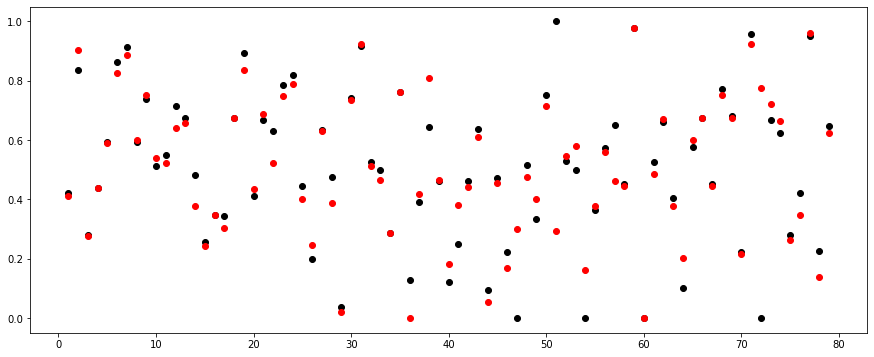

In [ ]:
#uceis_list=[12,34,56,78,90]
#uceis_list_outsample=[13,35,57,79,91]
plt.figure(figsize=(15, 6))
x = np.arange(start=1, stop=len(uceis_list)+1)
plt.plot(x, uceis_list, 'o', color='black')
plt.plot(x, uceis_list_outsample, 'o', color='red')
plt.show()


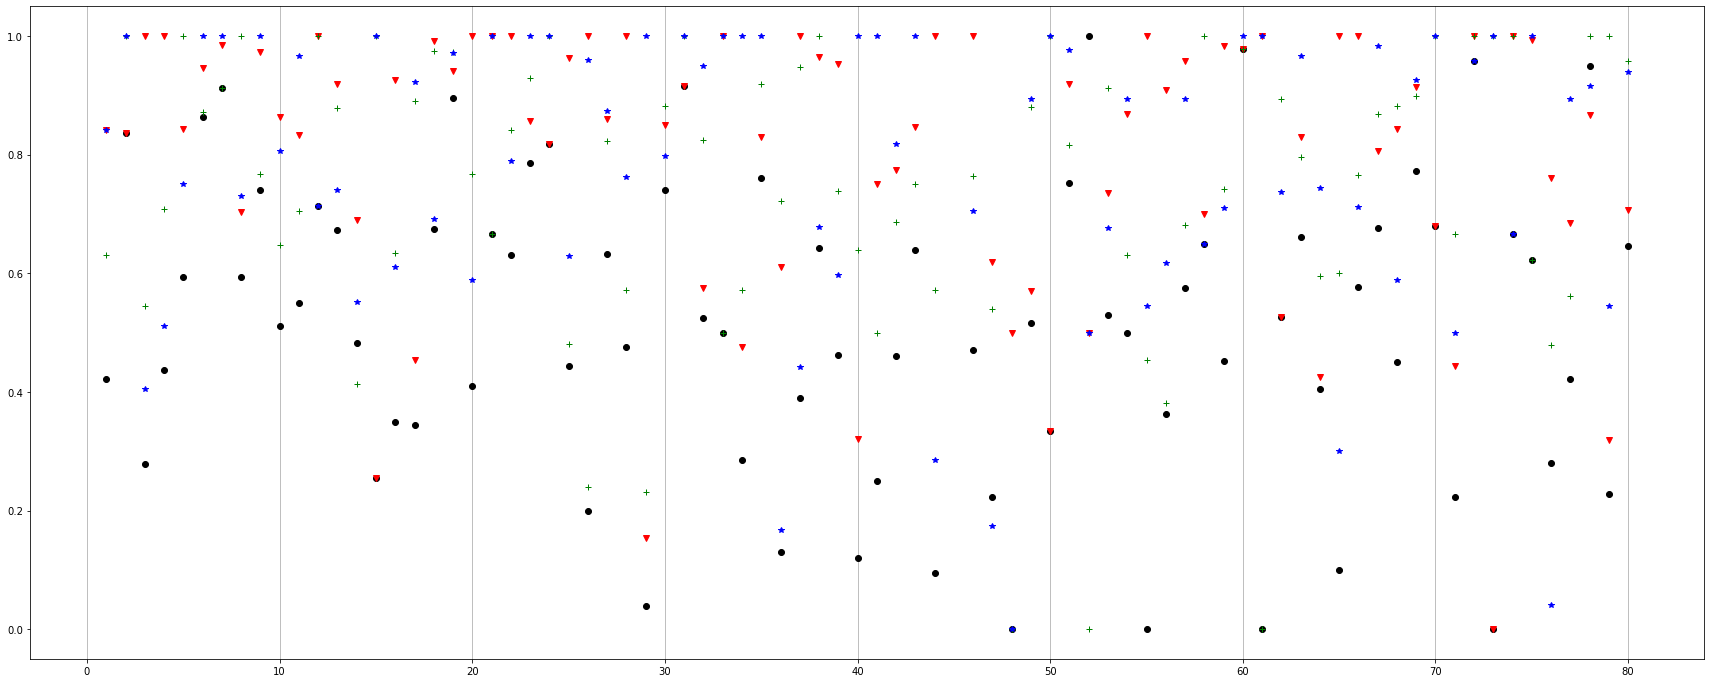

In [102]:
plt.figure(figsize=(30, 12))
x = np.arange(start=1, stop=len(uceis_list)+1)
plt.plot(x, uceis_list, 'o', color='black')
plt.plot(x, vascular_list, 'v', color='red')
plt.plot(x, bleeding_list, '+', color='green')
plt.plot(x, erosion_list, '*', color='blue')
plt.grid(axis = 'x', which='both')
plt.show()

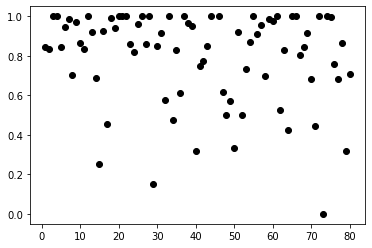

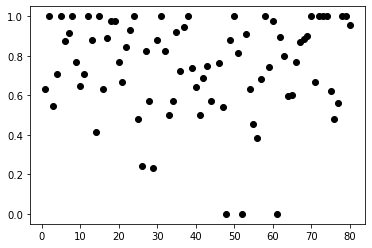

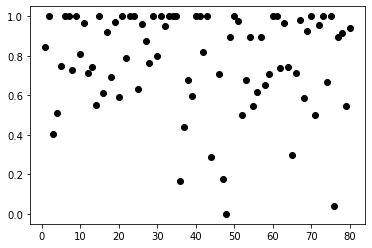

In [69]:
x = np.arange(start=1, stop=len(vascular_list)+1)
plt.plot(x, vascular_list, 'o', color='black')
plt.show()
x = np.arange(start=1, stop=len(bleeding_list)+1)
plt.plot(x, bleeding_list, 'o', color='black')
plt.show()
x = np.arange(start=1, stop=len(erosion_list)+1)
plt.plot(x, erosion_list, 'o', color='black')
plt.show()

In [38]:
normalize = transforms.Normalize(mean=[0.3682399440284867, 0.2694662632497621, 0.20368512286738416],
                                 std=[0.3335210190878823, 0.2446521312241275, 0.19399928544661488])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     normalize])

#test_dataset = UCEIS_cord(train_folders, frame_root, cord_project_ID, cord_API_key, transform=test_transform)
test_dataset = UCEIS_csv(train_folders, csv_filename=r'C:\Users\elif\Desktop\gi\labelx20.csv', transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_worker,
                                          pin_memory=True)

print("Images in test set: "+str(len(test_dataset)))

Images in test set: 7264


In [39]:
#state_dict_name = "weights/6_best_"+model_name+".pth.tar"
#state_dict_name = "weights/3_best_"+model_name+".pth.tar"
#state_dict_name = "weights/3_best_"+model_name+".pth.tar"
#state_dict_name = "weights/4_best_"+model_name+"_1.pth.tar"
#state_dict_name = "weights/4_best_"+model_name+"_2.pth.tar"
#state_dict_name = "weights/8_best_"+model_name+".pth.tar"

#### Model I used for Surgease paper results
state_dict_name = "weights/9_best_"+model_name+".pth.tar"

if model_name == "ResNet18":
    model = resnet.resnet18(num_classes=[3, 4, 4])
elif model_name == "ResNet34":
    model = resnet.resnet34(num_classes=[3, 4, 4])
elif model_name == "ResNet50":
    model = resnet.resnet50(num_classes=[3, 4, 4])
elif model_name == "DenseNet201":
    model = densenet.densenet201(num_classes=[3, 4, 4])
elif model_name == "DenseNet121":
    model = densenet.densenet121(num_classes=[3, 4, 4])

model.load_state_dict(torch.load(state_dict_name, map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
y_true_UCEIS = []
y_true_vascular = []
y_true_bleeding = []
y_true_erosion = []

y_pred_UCEIS = []
y_pred_vascular = []
y_pred_bleeding = []
y_pred_erosion = []

with torch.no_grad():
    for id, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        target.transpose_(0, 1)

        y_true_vascular.append(target[0].item())
        y_true_bleeding.append(target[1].item())
        y_true_erosion.append(target[2].item())
        y_true_UCEIS.append(target.sum().item())

        output = model(data)

        prediction_0 = output[0].argmax(dim=1, keepdim=True)[0][0].item()
        y_pred_vascular.append(prediction_0)

        prediction_1 = output[1].argmax(dim=1, keepdim=True)[0][0].item()
        y_pred_bleeding.append(prediction_1)

        prediction_2 = output[2].argmax(dim=1, keepdim=True)[0][0].item()
        y_pred_erosion.append(prediction_2)

        y_pred_UCEIS.append(prediction_0 + prediction_1 + prediction_2)


Vascular Accuracy:  0.8430616740088106
Confusion matrix, without normalization
[[ 174  273   49]
 [  42 2417  583]
 [   4  189 3533]]


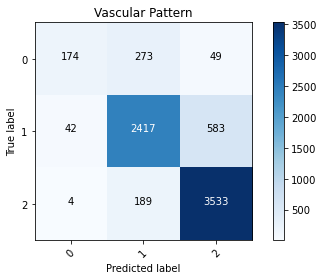

---------------------------------------

Bleeding Accuracy:  0.8284691629955947
Confusion matrix, without normalization
[[4315   28  173   41]
 [ 238  243  194   13]
 [ 325   22  932   45]
 [ 120    0   47  528]]


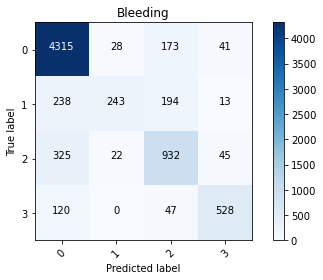

---------------------------------------

Erosion Accuracy:  0.8546255506607929
Confusion matrix, without normalization
[[5343  155    7   55]
 [ 550  726    1   26]
 [ 103   68    4   15]
 [  35   37    4  135]]


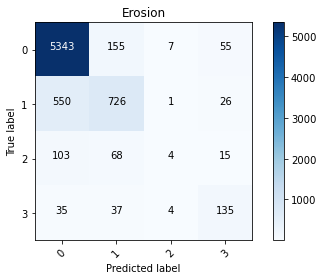

---------------------------------------

UCEIS Accuracy:  0.6287169603524229
Confusion matrix, without normalization
[[ 141  234   39   16    1    0    0    0    0]
 [  33 1484  272   30   29    3    0    0    0]
 [   5  231 1455  110   50   24    0    0    3]
 [   1   69  322  466  153   91    1   12    3]
 [   0   89  191   74  609  139    1    2    5]
 [   0    4   57   67  107  340    2    4   29]
 [   0    1   12   21   30   49    4    5   19]
 [   0    0    2    7   13   23    0   15    6]
 [   0    0    0    0    0    6    0    0   53]]


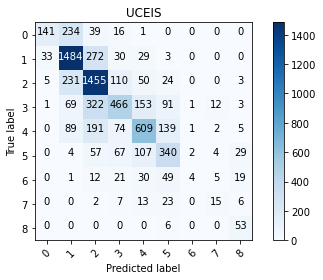

In [42]:
cm_vascular = confusion_matrix(y_true_vascular, y_pred_vascular, labels=[0, 1, 2])
accuracy_vascular = accuracy_score(y_true_vascular, y_pred_vascular)

cm_bleeding = confusion_matrix(y_true_bleeding, y_pred_bleeding, labels=[0, 1, 2, 3])
accuracy_bleeding = accuracy_score(y_true_bleeding, y_pred_bleeding)

cm_erosion = confusion_matrix(y_true_erosion, y_pred_erosion, labels=[0, 1, 2, 3])
accuracy_erosion = accuracy_score(y_true_erosion, y_pred_erosion)

cm_UCEIS = confusion_matrix(y_true_UCEIS, y_pred_UCEIS, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
accuracy_UCEIS = accuracy_score(y_true_UCEIS, y_pred_UCEIS)


print("Vascular Accuracy: ", accuracy_vascular)
plot_confusion_matrix_2(cm_vascular, classes=["0", "1", "2"], title="Vascular Pattern")
plt.show()
print("---------------------------------------\n")

print("Bleeding Accuracy: ", accuracy_bleeding)
plot_confusion_matrix_2(cm_bleeding, classes=["0", "1", "2", "3"], title="Bleeding")
plt.show()
print("---------------------------------------\n")

print("Erosion Accuracy: ", accuracy_erosion)
plot_confusion_matrix_2(cm_erosion, classes=["0", "1", "2", "3"], title="Erosion")
plt.show()
print("---------------------------------------\n")

print("UCEIS Accuracy: ", accuracy_UCEIS)
plot_confusion_matrix_2(cm_UCEIS, classes=["0", "1", "2", "3", "4", "5", "6", "7", "8"], title="UCEIS")
plt.show()

**Bucketing scores for different bucket levels**

[0.27848101265822783, 0.5379746835443038, 0.8860759493670886, 0.9367088607594937, 0.9936708860759493, 1.0, 1.0, 1.0, 1.0]


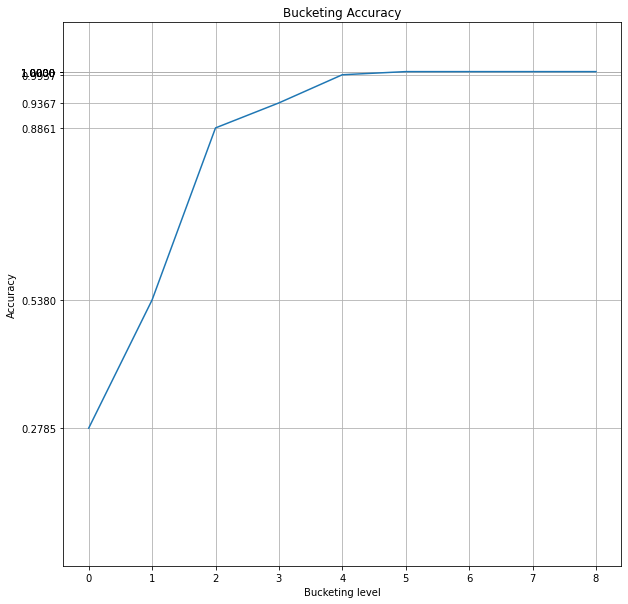

In [31]:
bucketing_scores = get_all_level_bucketing_accuracy(y_true_UCEIS, y_pred_UCEIS)
print(bucketing_scores)
plt.figure(figsize=(10,10))
plt.plot(bucketing_scores)
plt.title("Bucketing Accuracy")
plt.xlabel("Bucketing level")
plt.ylabel("Accuracy")
plt.yticks(bucketing_scores)
plt.grid(True)
plt.ylim(0, 1.1)
plt.show()

**Video level quadratic weighted kappa score**

In [170]:
quadratic_kappa_score = cohen_kappa_score(y_true_UCEIS, y_pred_UCEIS, weights="quadratic")
print("Quadratic Kappa Score (9-classes): ", quadratic_kappa_score)

Quadratic Kappa Score (9-classes):  0.8979798079482002


In [171]:
quadratic_kappa_score = cohen_kappa_score(y_true_bleeding, y_pred_bleeding, weights="quadratic")
print("Quadratic Kappa Score (9-classes): ", quadratic_kappa_score)

Quadratic Kappa Score (9-classes):  0.7441472162174015


In [172]:
quadratic_kappa_score = cohen_kappa_score(y_true_vascular, y_pred_vascular, weights="quadratic")
print("Quadratic Kappa Score (9-classes): ", quadratic_kappa_score)

Quadratic Kappa Score (9-classes):  0.7401452264733981


In [173]:
quadratic_kappa_score = cohen_kappa_score(y_true_erosion, y_pred_erosion, weights="quadratic")
print("Quadratic Kappa Score (9-classes): ", quadratic_kappa_score)

Quadratic Kappa Score (9-classes):  0.8810388288892487


**Video level remission results**

UCEIS Accuracy (0 vs 1-8):  0.8763608087091758
Confusion matrix, without normalization
[[ 675  322]
 [ 314 3833]]


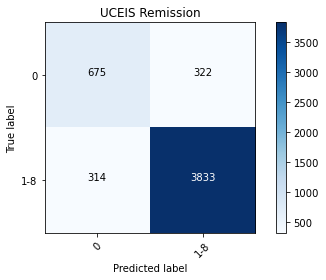

In [174]:
y_true_remission = convert_multiclass_to_binary_class(y_true_UCEIS)
y_pred_remission = convert_multiclass_to_binary_class(y_pred_UCEIS)

cm_UCEIS_remission = confusion_matrix(y_true_remission, y_pred_remission, labels=[0, 1])
accuracy_UCEIS_remission = accuracy_score(y_true_remission, y_pred_remission)

print("UCEIS Accuracy (0 vs 1-8): ", accuracy_UCEIS_remission)
plot_confusion_matrix_2(cm_UCEIS_remission, classes=["0", "1-8"], title="UCEIS Remission")
plt.show()

**Video level remission kappa score**

In [175]:
kappa_score = cohen_kappa_score(y_true_remission, y_pred_remission)
print("Remission Kappa Score: ", kappa_score)

Remission Kappa Score:  0.6031518023347636


In [38]:
cm_UCEIS[0][0] + cm_UCEIS[0][1]+cm_UCEIS[1][1] + cm_UCEIS[1][0]

729

In [44]:
sum(cm_UCEIS[3:][0]) + sum(cm_UCEIS[3:][1]) + sum(cm_UCEIS[0][3:]) + sum(cm_UCEIS[1][3:])

818

In [94]:
cm_UCEIS

array([[3249,  281,    0,    0,    0,    0,    0,    0,    0],
       [ 417,  863,    9,    0,    0,    0,    0,    0,    0],
       [ 120,  575,  203,   16,    2,    0,    0,    0,    0],
       [   0,    5,   22,   15,   67,    5,    0,    0,    0],
       [   0,    0,    1,    4, 1209,  153,    0,    0,    0],
       [   0,    0,    0,    5,  191,  494,    0,    1,    0],
       [   0,    0,    0,    0,  144,   24,    0,    0,    0],
       [   0,    0,    0,    0,    0,  301,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [183]:
import pandas as pd
df = pd.DataFrame(cm_UCEIS)
df.to_csv('./results/train_test_w_no_val_uceis.csv')

In [184]:
import pandas as pd
df = pd.DataFrame(cm_vascular)
df.to_csv('./results/train_test_w_no_val_vascular.csv')

In [185]:
import pandas as pd
df = pd.DataFrame(cm_bleeding)
df.to_csv('./results/train_test_w_no_val_bleeding.csv')

In [186]:
import pandas as pd
df = pd.DataFrame(cm_erosion)
df.to_csv('./results/train_test_w_no_val_erosion.csv')

In [181]:
import pandas as pd
df = pd.DataFrame(cm_UCEIS)

In [113]:
(cm_UCEIS[4:,4:])


array([[1209,  153,    0,    0,    0],
       [ 191,  494,    0,    1,    0],
       [ 144,   24,    0,    0,    0],
       [   0,  301,    0,    0,    0],
       [   0,    0,    0,    0,    0]])

In [114]:
(cm_UCEIS[0:4,0:4])

array([[3249,  281,    0,    0],
       [ 417,  863,    9,    0],
       [ 120,  575,  203,   16],
       [   0,    5,   22,   15]])

In [179]:
(sum(sum((cm_UCEIS[0:4,0:4]))) + sum(sum((cm_UCEIS[4:,4:]))) )/ sum(sum(cm_UCEIS))

0.9844479004665629

In [73]:
2817.0/2897

0.9723852260959613

In [108]:
sum(sum(cm_UCEIS))

8376

In [176]:
(sum(sum((cm_UCEIS[0:2,0:2]))) + sum(sum((cm_UCEIS[2:,2:]))) )/ sum(sum(cm_UCEIS))

0.7857698289269052

In [178]:
cm_UCEIS[2:,2:]

array([[757,  16,   2,   0,   0,   0,   0],
       [ 42,  27,  67,   5,   0,   0,   0],
       [  1,   1, 550, 152,   0,   0,   0],
       [  0,   4, 191,  29,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 301,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

In [119]:
7667.0/8376

0.9153533906399236

In [117]:
(cm_UCEIS[2:,2:])

array([[ 203,   16,    2,    0,    0,    0,    0],
       [  22,   15,   67,    5,    0,    0,    0],
       [   1,    4, 1209,  153,    0,    0,    0],
       [   0,    5,  191,  494,    0,    1,    0],
       [   0,    0,  144,   24,    0,    0,    0],
       [   0,    0,    0,  301,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0]])

In [116]:
(cm_UCEIS[0:2,0:2])

array([[3249,  281],
       [ 417,  863]])

In [42]:
(sum(cm_UCEIS[2:][0]) + sum(cm_UCEIS[2:][1]) + sum(cm_UCEIS[0][2:]) + sum(cm_UCEIS[1][2:]))*1.0 / sum(sum(cm_UCEIS))

0.3241284086986538

In [232]:
8233/19396.0

0.424468962672716

In [233]:
1-_

0.575531037327284

In [ ]:
###Fold 1 : 83.56 1 bucket , 87,6 remission
###Fold 2 : 84.74 1 bucket , 91.9 remission

In [58]:
len(y_pred_vascular)

37107

In [60]:
import pandas as pd

d=pd.DataFrame((test_loader.dataset.frame_paths))
d[1] = d[0].str.split('/').apply(lambda x:x[-3])
d[1].unique()

In [37]:
file = open("splitted_folder_names/predetermined_test_folders.txt", "r")
test_folders = file.read().splitlines()

In [38]:
test_folders

['UC10-0.mp4',
 'UC15-1.mp4',
 'UC21-2.mp4',
 'UC14-4.mp4',
 'UC53-4.mp4',
 'UC61-4.mp4',
 'UC79-4.mp4',
 'UC29-5.mp4',
 'UC30-5.mp4',
 'UC1-6.mp4']

In [39]:
len(y_true_UCEIS)

3297

In [11]:
import gc
import torch

gc.collect()

torch.cuda.empty_cache()
gc.collect()


0

3297

In [25]:
np.array([[3249,  281,    0,    0,    0,    0,    0,    0,    0],
       [ 417,  863,    9,    0,    0,    0,    0,    0,    0],
       [ 120,  575,  203,   16,    2,    0,    0,    0,    0],
       [   0,    5,   22,   15,   67,    5,    0,    0,    0],
       [   0,    0,    1,    4, 1209,  153,    0,    0,    0],
       [   0,    0,    0,    5,  191,  494,    0,    1,    0],
       [   0,    0,    0,    0,  144,   24,    0,    0,    0],
       [   0,    0,    0,    0,    0,  301,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]])

array([[3249,  281,    0,    0,    0,    0,    0,    0,    0],
       [ 417,  863,    9,    0,    0,    0,    0,    0,    0],
       [ 120,  575,  203,   16,    2,    0,    0,    0,    0],
       [   0,    5,   22,   15,   67,    5,    0,    0,    0],
       [   0,    0,    1,    4, 1209,  153,    0,    0,    0],
       [   0,    0,    0,    5,  191,  494,    0,    1,    0],
       [   0,    0,    0,    0,  144,   24,    0,    0,    0],
       [   0,    0,    0,    0,    0,  301,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [26]:
cm_UCEIS = _

In [29]:
sum(sum(cm_UCEIS))

8376

In [ ]:
[[ 675  322]
 [ 314 3833]]